In [19]:
#Import libraries

import ee 
import geemap
import xee
import xarray as xr
import datetime
import rioxarray as rxr
import os
import ipyleaflet
import gdown
import rasterio
from rasterio import features
from osgeo import gdal, ogr, osr
import os, glob, re, csv
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import json
import geopandas as gpd
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, colors, rc
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates

In [20]:
#Inputs:
pf = "14_387" #manually input, since GEE index differently!

cwd = os.getcwd()
json_path = os.path.join(cwd, "dict.json")

with open(json_path, "r") as file:
    loaded_sar_data = json.load(file)

path = int(next(iter(loaded_sar_data['1']['path_frame_dict'])))
frame = int(loaded_sar_data['1']['path_frame_dict'][str(path)][0])
#print(path, frame)
out_nc_fn = loaded_sar_data['1']['cube_fn']
filename = os.path.basename(out_nc_fn)   
rgi_id = filename.split("_")[1].split(".")[0]
tifs_path = os.path.join(cwd, 'tifs_single_glacier') #type Path
gl_path = os.path.join(tifs_path, rgi_id)
csv_path = os.path.join(cwd, 'csv\\')
fig_fp = os.path.join(cwd, 'fig\\')
dem_path = os.path.join(gl_path, 'DEM.tif')
print(str(dem_path))

# all processed path/frame datacubes
loaded_sar_data

c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05702\DEM.tif


{'1': {'location_str': 'Kennicott',
  'scene_name': 'Kennicott',
  'cube_fn': 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\merged_01-05702.nc',
  'epsg_no': '32607',
  'path_frame_dict': {'14': ['5']},
  'Direction': 'Ascending',
  'frame_cut': 0,
  'pol_str': 'VH'}}

In [21]:
#Inputs:
rgi_id_period = rgi_id.replace("-", ".")
glacno = int(rgi_id[-5:])

u_path = os.path.join(csv_path, rgi_id_period)
for filename in os.listdir(u_path):
    print(filename)

#make sure to unzip!
corr_path = os.path.join(cwd, f'albin_data\\{rgi_id_period}')

for filename in os.listdir(corr_path):
    if pf in filename:
        print(filename)

01.05702_db_bin_mean_14-387.csv
01.05702_db_bin_mean_14-387_eabin.csv
01.05702_hypsometry_14-387.csv
01.05702_hypsometry_14-387_eabin.csv
01.05702_melt_extent_elev_percentile_14-387.csv
01.05702_melt_extent_elev_percentile_14-387_eabin.csv
01.05702_snowline_elev_percentile_14-387.csv
01.05702_snowline_elev_percentile_14-387_eabin.csv
01.05702_db_bin_mean_014_387_392.csv
01.05702_db_bin_mean_014_387_392_eabin.csv
01.05702_hypsometry_014_387_392.csv
01.05702_hypsometry_014_387_392_eabin.csv
01.05702_melt_extent_elev_percentile_014_387_392.csv
01.05702_melt_extent_elev_percentile_014_387_392_eabin.csv
01.05702_melt_extent_elev_percentile_eos_corr_014_387_392.csv
01.05702_snowline_elev_percentile_014_387_392.csv
01.05702_snowline_elev_percentile_014_387_392_eabin.csv
01.05702_snowline_elev_percentile_eos_corr_014_387_392.csv


In [22]:

reg_glacno_str = rgi_id_period

u_glac_me_elev_perc_fps = glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_melt_extent_elev_percentile_*.csv')) # percentile method
u_glac_sl_elev_perc_fps = glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_snowline_elev_percentile_*.csv')) # percentile method
u_glac_bin_onset_fps = glob.glob(os.path.join(u_path, f'*{reg_glacno_str}-bin_yearly_onset_date_*.csv')) # melt onset in each elevation bin
u_glac_hyps_fps = glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_hypsometry_*.csv')) # hypsometry (area per elevation bin)
u_glac_db_mean_fps = glob.glob(os.path.join(u_path, f'*{reg_glacno_str}_db_bin_mean_*.csv')) # binned backscatter

print(u_glac_me_elev_perc_fps, u_glac_sl_elev_perc_fps, u_glac_bin_onset_fps)

['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05702\\01.05702_melt_extent_elev_percentile_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05702\\01.05702_melt_extent_elev_percentile_14-387_eabin.csv'] ['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05702\\01.05702_snowline_elev_percentile_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05702\\01.05702_snowline_elev_percentile_14-387_eabin.csv'] []


In [23]:

corr_glac_me_elev_perc_fps = glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_melt_extent_elev_percentile_*.csv')) # percentile method
corr_glac_sl_elev_perc_fps = glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_snowline_elev_percentile_*.csv')) # percentile method
corr_glac_bin_onset_fps = glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}-bin_yearly_onset_date_*.csv')) # melt onset in each elevation bin
corr_glac_hyps_fps = glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_hypsometry_*.csv')) # hypsometry (area per elevation bin)
corr_glac_db_mean_fps = glob.glob(os.path.join(corr_path, f'*{reg_glacno_str}_db_bin_mean_*.csv')) # binned backscatter

print(corr_glac_me_elev_perc_fps, corr_glac_sl_elev_perc_fps, corr_glac_bin_onset_fps)

['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_melt_extent_elev_percentile_014_387_392.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_melt_extent_elev_percentile_014_387_392_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_melt_extent_elev_percentile_116_386_391.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_melt_extent_elev_percentile_116_386_391_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_melt_extent_elev_percentile_123_197_202.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_melt_extent_elev_percentile_123_197_202_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_melt_extent_elev_percentile_eos_corr_014_387_392.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\albin_data\\01.05702\\01.05702_me

In [24]:
# sort files by equal area (ea) and equal elevation (z) bins
u_glac_me_elev_perc_z_fps = [fp for fp in u_glac_me_elev_perc_fps if "_eabin" not in fp]
u_glac_sl_elev_perc_z_fps = [fp for fp in u_glac_sl_elev_perc_fps if "_eabin" not in fp]
u_glac_bin_onset_z_fps = [fp for fp in u_glac_bin_onset_fps if "_eabin" not in fp]
u_glac_db_mean_z_fps = [fp for fp in u_glac_db_mean_fps if "_eabin" not in fp]
u_glac_hyps_z_fps = [fp for fp in u_glac_hyps_fps if "_eabin" not in fp]

u_glac_me_elev_perc_ea_fps = [fp for fp in u_glac_me_elev_perc_fps if "_eabin" in fp]
u_glac_sl_elev_perc_ea_fps = [fp for fp in u_glac_sl_elev_perc_fps if "_eabin" in fp]
u_glac_bin_onset_ea_fps = [fp for fp in u_glac_bin_onset_fps if "_eabin" in fp]
u_glac_db_mean_ea_fps = [fp for fp in u_glac_db_mean_fps if "_eabin" in fp]
u_glac_hyps_ea_fps = [fp for fp in u_glac_hyps_fps if "_eabin" in fp]

print(f'A total of {len(u_glac_db_mean_z_fps)} paths have been processed for glacier RGI {rgi_id_period}')

A total of 1 paths have been processed for glacier RGI 01.05702


In [25]:
# sort files by equal area (ea) and equal elevation (z) bins
corr_glac_me_elev_perc_z_fps = [fp for fp in corr_glac_me_elev_perc_fps if "_eabin" not in fp]
corr_glac_sl_elev_perc_z_fps = [fp for fp in corr_glac_sl_elev_perc_fps if "_eabin" not in fp]
corr_glac_bin_onset_z_fps = [fp for fp in corr_glac_bin_onset_fps if "_eabin" not in fp]
corr_glac_db_mean_z_fps = [fp for fp in corr_glac_db_mean_fps if "_eabin" not in fp]
corr_glac_hyps_z_fps = [fp for fp in corr_glac_hyps_fps if "_eabin" not in fp]

corr_glac_me_elev_perc_ea_fps = [fp for fp in corr_glac_me_elev_perc_fps if "_eabin" in fp]
corr_glac_sl_elev_perc_ea_fps = [fp for fp in corr_glac_sl_elev_perc_fps if "_eabin" in fp]
corr_glac_bin_onset_ea_fps = [fp for fp in corr_glac_bin_onset_fps if "_eabin" in fp]
corr_glac_db_mean_ea_fps = [fp for fp in corr_glac_db_mean_fps if "_eabin" in fp]
corr_glac_hyps_ea_fps = [fp for fp in corr_glac_hyps_fps if "_eabin" in fp]

print(f'A total of {len(corr_glac_db_mean_z_fps)} paths have been processed for glacier RGI {rgi_id_period}')

A total of 3 paths have been processed for glacier RGI 01.05702


Direct csv snowline comparison:

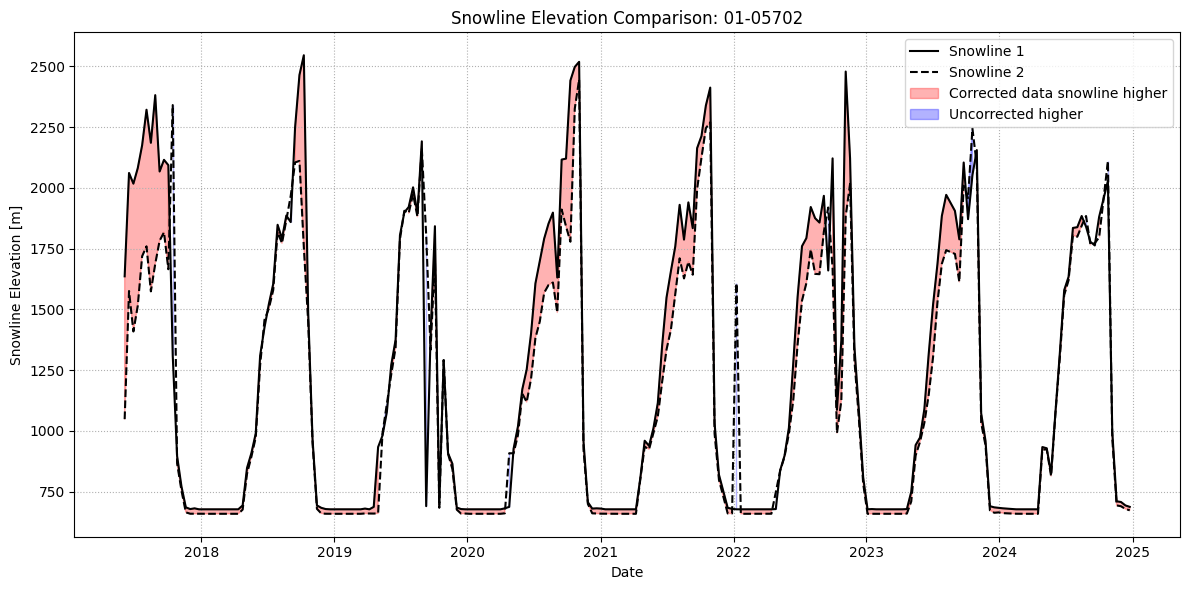

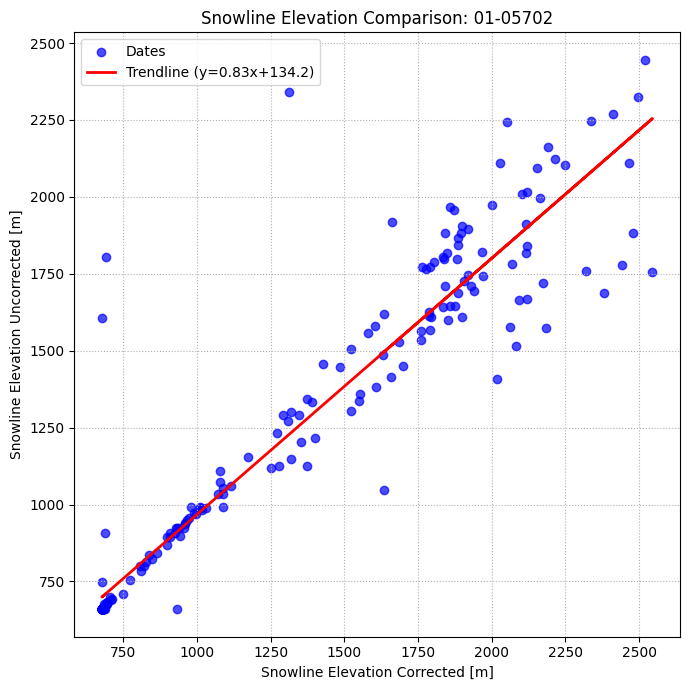

In [26]:
csv_1 = u_glac_sl_elev_perc_z_fps[0]
csv_2 = [x for x in corr_glac_sl_elev_perc_z_fps if pf in x and "eos" not in x][0]
csv_2

corr_sl_df = pd.read_csv(csv_2, index_col=0, parse_dates=True)
u_sl_df = pd.read_csv(csv_1, index_col=0, parse_dates=True)

# Shape (rows, columns)
# print("Shapes:", corr_sl_df.shape, u_sl_df.shape)

# Column headers
# print("Headers:", corr_sl_df.columns.tolist())

# Merge on dates (inner join ensures only matching dates)
merged = corr_sl_df[['snowline_elev_m']].rename(columns={'snowline_elev_m': 'snowline1'})
merged['snowline2'] = u_sl_df['snowline_elev_m']

# Compute difference
merged['diff'] = merged['snowline1'] - merged['snowline2']

# Plot
plt.figure(figsize=(12,6))

# black straight lines (no dots)
plt.plot(merged.index, merged['snowline1'], color="black", linewidth=1.5, label="Snowline 1")
plt.plot(merged.index, merged['snowline2'], color="black", linewidth=1.5, linestyle="--", label="Snowline 2")

# Highlight differences
plt.fill_between(
    merged.index,
    merged['snowline1'], merged['snowline2'],
    where=merged['snowline1'] > merged['snowline2'],
    color='red', alpha=0.3, label="Corrected data snowline higher"
)
plt.fill_between(
    merged.index,
    merged['snowline1'], merged['snowline2'],
    where=merged['snowline1'] < merged['snowline2'],
    color='blue', alpha=0.3, label="Uncorrected higher"
)

plt.xlabel("Date")
plt.ylabel("Snowline Elevation [m]")
plt.title(f"Snowline Elevation Comparison: {rgi_id}")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
png_fp = os.path.join(fig_fp, f"snowline_cmp_{rgi_id}.png")
plt.savefig(png_fp, dpi=300, bbox_inches='tight')  # high-quality PNG
plt.show()

#comparison plot
x = merged['snowline1'].values
y = merged['snowline2'].values

plt.figure(figsize=(7,7))
plt.scatter(x, y, c='blue', alpha=0.7, label="Dates")

# Add regression (trendline)
m, b = np.polyfit(x, y, 1)   # slope, intercept
plt.plot(x, m*x + b, color="red", linewidth=2, label=f"Trendline (y={m:.2f}x+{b:.1f})")

plt.xlabel("Snowline Elevation Corrected [m]")
plt.ylabel("Snowline Elevation Uncorrected [m]")
plt.title(f"Snowline Elevation Comparison: {rgi_id}")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
png_fp = os.path.join(fig_fp, f"snowline_dot_cmp_{rgi_id}.png")
plt.savefig(png_fp, dpi=300, bbox_inches='tight')  # high-quality PNG

plt.show()


Melt Extent Comparison:

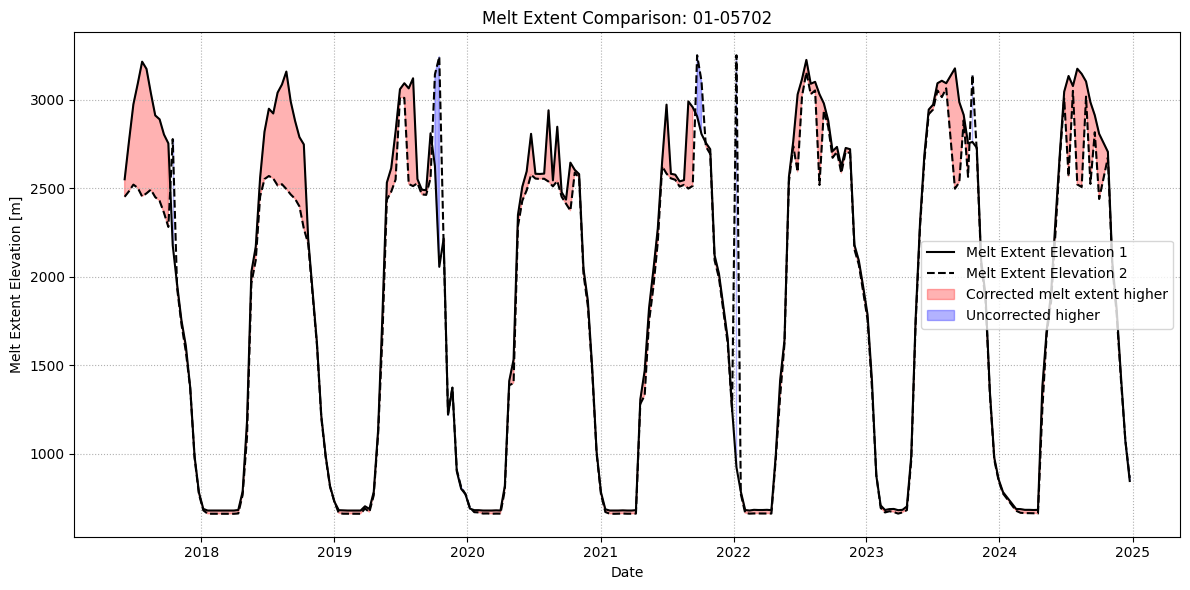

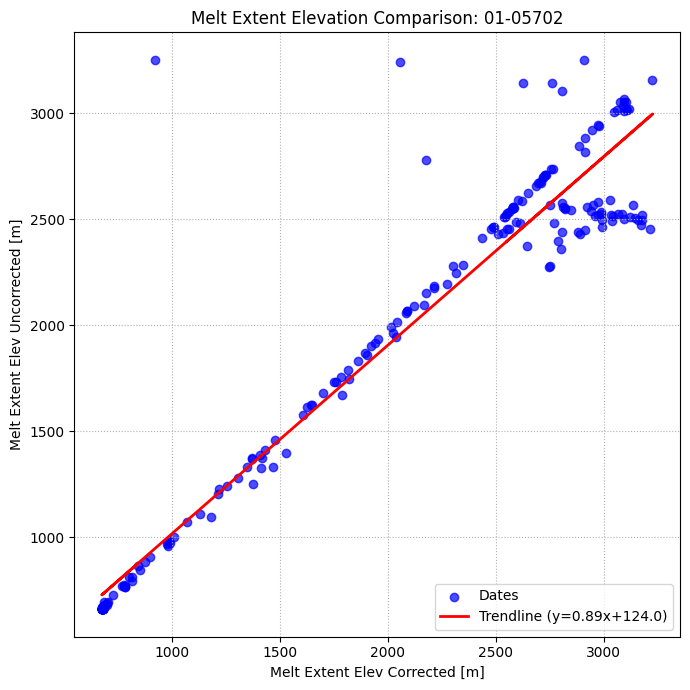

In [27]:
csv_1 = u_glac_me_elev_perc_z_fps[0]
csv_2 = [x for x in corr_glac_me_elev_perc_z_fps if pf in x and "eos" not in x][0]
csv_2

corr_me_df = pd.read_csv(csv_2, index_col=0, parse_dates=True)
u_me_df = pd.read_csv(csv_1, index_col=0, parse_dates=True)

# Shape (rows, columns)
# print("Shapes:", corr_sl_df.shape, u_sl_df.shape)

# Column headers
# print("Headers:", corr_sl_df.columns.tolist())

# Merge on dates (inner join ensures only matching dates)
merged = corr_me_df[['melt_extent_elev_m']].rename(columns={'melt_extent_elev_m': 'me1'})
merged['me2'] = u_me_df['melt_extent_elev_m']

# Compute difference
merged['diff'] = merged['me1'] - merged['me2']

# Plot
plt.figure(figsize=(12,6))

# black straight lines (no dots)
plt.plot(merged.index, merged['me1'], color="black", linewidth=1.5, label="Melt Extent Elevation 1")
plt.plot(merged.index, merged['me2'], color="black", linewidth=1.5, linestyle="--", label="Melt Extent Elevation 2")

# Highlight differences
plt.fill_between(
    merged.index,
    merged['me1'], merged['me2'],
    where=merged['me1'] > merged['me2'],
    color='red', alpha=0.3, label="Corrected melt extent higher"
)
plt.fill_between(
    merged.index,
    merged['me1'], merged['me2'],
    where=merged['me1'] < merged['me2'],
    color='blue', alpha=0.3, label="Uncorrected higher"
)

plt.xlabel("Date")
plt.ylabel("Melt Extent Elevation [m]")
plt.title(f"Melt Extent Comparison: {rgi_id}")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
png_fp = os.path.join(fig_fp, f"me_cmp_{rgi_id}.png")
plt.savefig(png_fp, dpi=300, bbox_inches='tight')  # high-quality PNG
plt.show()

#comparison plot
x = merged['me1'].values
y = merged['me2'].values

plt.figure(figsize=(7,7))
plt.scatter(x, y, c='blue', alpha=0.7, label="Dates")

# Add regression (trendline)
m, b = np.polyfit(x, y, 1)   # slope, intercept
plt.plot(x, m*x + b, color="red", linewidth=2, label=f"Trendline (y={m:.2f}x+{b:.1f})")

plt.xlabel("Melt Extent Elev Corrected [m]")
plt.ylabel("Melt Extent Elev Uncorrected [m]")
plt.title(f"Melt Extent Elevation Comparison: {rgi_id}")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
png_fp = os.path.join(fig_fp, f"me_dot_cmp_{rgi_id}.png")
plt.savefig(png_fp, dpi=300, bbox_inches='tight')  # high-quality PNG

plt.show()